In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load Trained model and Test Set

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [3]:
from keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
model = load_model(weights_path)

In [4]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [5]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

0 7 3.5
1e-08 1.0000000000000016 0.004623813018385694


In [6]:
X_test = np.log(X_test_raw)
X_test = np.expand_dims(X_test, axis = -1)

In [7]:
print(y_test[:5])

[7 5 5 5 5]


### Defines key variables

In [8]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 32
EPOCH_COUNT = 50
L2_regularization = 0.001

### Model Summary 

In [9]:
# Not important
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_latest.png', show_shapes=True, show_layer_names=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 319, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  1568        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

### Activation Visulaization using Keras-viz
https://github.com/raghakot/keras-vis

Can be used to visualized each individual filter of a certain layer. In the example below we are using conv_1(the first convolutional layer of the model) but it can be any layer.

In [10]:
from keras_vis.vis.visualization import visualize_activation
from keras_vis.vis.visualization import visualize_saliency
from keras_vis.vis.utils import utils
from keras import activations

In [11]:
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

### Filters for Convolution Block 1

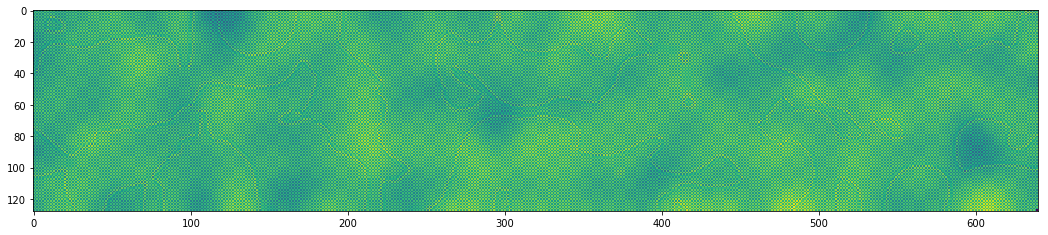

In [12]:
filters=[]
#layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'conv_1')
# This is the output node we want to maximize.
for filter_idx in range(nb_filters1):
    #filter_idx = 1
    plt.rcParams['figure.figsize'] = (18, 6)
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
    filters.append(img)
    plt.imshow(img[..., 0].T)
    #lt.savefig(str(filter_idx)+'.png')

Num Filters is:  16
Stitched shape:  (1285, 1059)


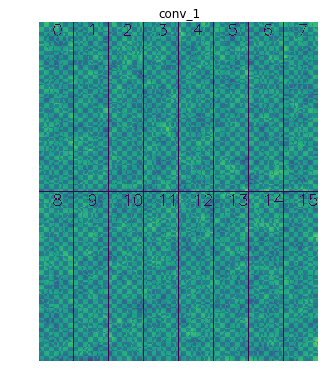

In [13]:
from keras_vis.vis.visualization import get_num_filters
import cv2

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv_1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))
print("Num Filters is: ", filters[-1]+1)
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(idx),(50,50), font, 2,(0,0,0),2) 
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
stitched = stitched.reshape(stitched.shape[0], stitched.shape[1])
print("Stitched shape: ", stitched.shape)
plt.rcParams['figure.figsize'] = (5, 15)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

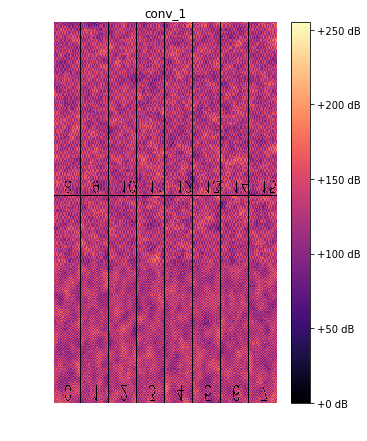

In [14]:
plt.rcParams['figure.figsize'] = (5, 7)
plt.axis('off')
librosa.display.specshow(stitched, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
# plt.imshow(stitched)
plt.title(layer_name)
plt.show()

### Filters for Convolution Block 5

Num Filters is:  64
Stitched shape:  (5155, 1059)


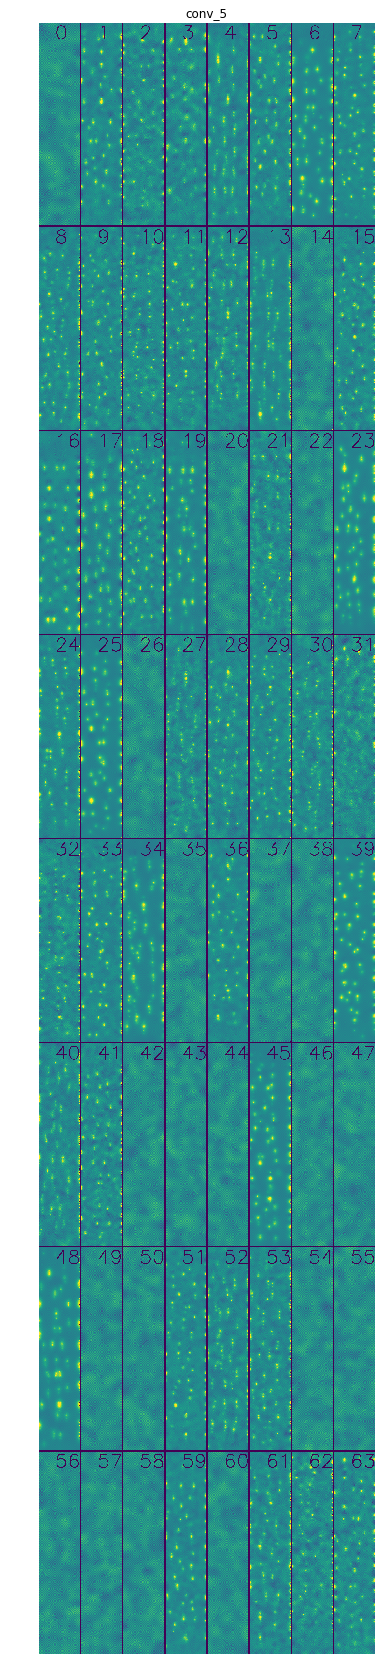

In [15]:
from keras_vis.vis.visualization import get_num_filters
import cv2

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv_5'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))
print("Num Filters is: ", filters[-1]+1)
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(idx),(50,50), font, 2,(0,0,0),2)   
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
stitched = stitched.reshape(stitched.shape[0], stitched.shape[1])
print("Stitched shape: ", stitched.shape)
plt.rcParams['figure.figsize'] = (10, 30)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

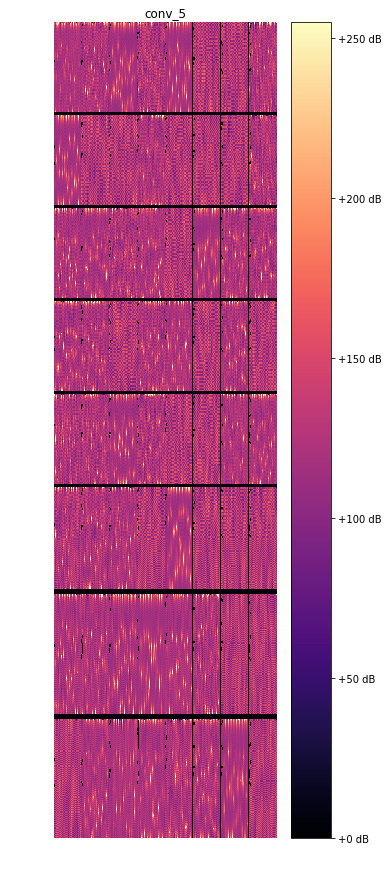

In [16]:
plt.rcParams['figure.figsize'] = (5, 15)
plt.axis('off')
librosa.display.specshow(stitched.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
# plt.imshow(stitched)
plt.title(layer_name)
plt.show()